# Airbnb Istanbul Pricing Analysis

This project analyzes Airbnb listing prices in Istanbul using publicly available data from Inside Airbnb.  
The goal is to understand what features (including location, room type, and user behavior) influence the nightly price.

> Dataset Date: December 30, 2024  
> Data Source: http://insideairbnb.com/get-the-data.html  
> Created by: Mustafa Nalbantli


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Objectives & Questions

- What are the main factors influencing Airbnb pricing in Istanbul?
- How does room type or neighborhood affect price?
- Can recent user activity (reviews) signal higher pricing?
- Can we predict the price of a listing using simple machine learning?


## Load the Data

Let’s load the Airbnb listings dataset for Istanbul (snapshot from December 2024), which contains price, location, room type, and various other attributes for each listing.


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

file_path = "/content/drive/MyDrive/airbnb_istanbul/listings.csv"
df = pd.read_csv(file_path)
df.shape
df.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,25436,https://www.airbnb.com/rooms/25436,20241230155630,2024-12-30,previous scrape,In the forest Sea view Two minutes to the city.,Our house is in Baby Koru. If you want village...,Clean and elegand friends . U can find everyth...,https://a0.muscache.com/pictures/b64c3ef0-2256...,105823,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
1,34177,https://www.airbnb.com/rooms/34177,20241230155630,2024-12-31,city scrape,PETIT HOUSE,My petit house is located in the bosphorous an...,the neighbourhood is very calm comparing the...,https://a0.muscache.com/pictures/47356451/c288...,147330,...,4.81,4.69,4.81,NaN,f,2,2,0,0,0.15
2,42835,https://www.airbnb.com/rooms/42835,20241230155630,2024-12-30,previous scrape,Cozy apartment in the heart of Istanbul,Welcome to our cozy 2-bedroom apartment locate...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,187026,...,NaN,NaN,NaN,NaN,f,3,1,2,0,NaN


## Data Cleaning & Initial Observations

After loading the raw dataset, it's time to take a closer look at the structure and quality of the data.

What variables will actually help us understand pricing?
What columns are missing too much information?
Are there outliers that could distort our analysis?

In this section, we'll answer these questions and prepare the data for exploration.


In [10]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
missing_percent = (missing / len(df) * 100).round(1)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_df

,Missing Count,Missing %
neighbourhood_group_cleansed,29400,100.0
calendar_updated,29400,100.0
host_neighbourhood,25598,87.1
neighbourhood,20532,69.8
neighborhood_overview,20532,69.8
host_about,17781,60.5
license,12979,44.1
review_scores_checkin,11323,38.5
review_scores_value,11323,38.5
review_scores_accuracy,11322,38.5


### Observation:

Several review-related fields such as `review_scores_accuracy`, `review_scores_value`, and `reviews_per_month` have notable missing values.

This is expected because many listings either don’t have reviews yet or have been inactive.  
Instead of dropping these variables entirely, I’ll handle them carefully:

- For modeling, I may choose to **fill or drop** based on importance  
- For EDA, I’ll keep them and explore whether **trust indicators** (review count, last review) correlate with price


## Exploratory Data Analysis: Price Distribution

Let’s start by exploring the overall distribution of listing prices in Istanbul.

This helps us understand whether prices are clustered, how wide the spread is, and whether outliers are skewing the data.

We’ll begin with basic statistics and a histogram.


In [11]:
df['price'].describe()

,price
count,25155
unique,5024
top,"$2,000.00"
freq,327


### Data Fix: Converting Price to Numeric Format

The `price` column was initially imported as an `object` (string) type due to the presence of dollar signs (`$`) and commas (`,`).

Since we want to perform numerical operations such as calculating quantiles, plotting histograms, and building models,  
we need to convert this column into a numeric (`float64`) format.

Here’s what we did:
- Removed currency symbols and commas using `str.replace()`  
- Used `pd.to_numeric()` with `errors='coerce'` to safely convert values and set invalid ones to `NaN`

This prepares the `price` column for proper statistical analysis.


In [12]:
df['price'] = df['price'].replace(r'[\$,]', '', regex=True)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [13]:
df['price'].quantile([0.01, 0.25, 0.5, 0.75, 0.95, 0.99])

,price
0.01,366.54
0.25,1538.00
0.50,2400.00
0.75,3835.00
0.95,9553.00
0.99,22940.00


### Observation:

The price distribution shows a significant skew, with most listings priced under ₺4,000 — but with a few extreme outliers.

Although the dataset marks prices with a `$` symbol, based on contextual understanding of Airbnb listings in Istanbul,  
**these values clearly reflect Turkish Lira (₺), not USD.**  
For example, a median value of ₺2,400 aligns with reasonable nightly rates in central Istanbul (~$60 USD equivalent, 07/17/2025).

Key quantiles:
- **1st percentile** → ₺366  
- **25th percentile** → ₺1,538  
- **Median (50th)** → ₺2,400  
- **75th percentile** → ₺3,835  
- **95th percentile** → ₺9,553  
- **99th percentile** → ₺22,940

We observe a long-tailed distribution: a small number of listings go far beyond the typical price range,  
likely reflecting ultra-luxury properties or entire buildings.

**For visualization and modeling, we may cap values at the 95th percentile (~₺9,500) to avoid distortion.**


## Data Fix: Cleaning the Price Column

While preparing my analysis, I noticed an issue with the `price` column.  
It was imported as an `object` (string), which prevented any meaningful statistical analysis or visualization.

Upon closer inspection, I found two specific problems:
- The values contained `$` signs and commas (e.g. `$2,100.00`) and were treated as strings
- A few entries contained unrelated text (e.g. `"Pocket wifi"`), likely due to parsing errors in the raw dataset

Since I plan to calculate summary statistics, create visualizations, and possibly build predictive models,  
this column must be converted into proper numeric format.

Here’s how I cleaned it:


In [ ]:
# Remove dollar signs and commas
df['price'] = df['price'].replace(r'[\$,]', '', regex=True)

# Convert to float — if it fails, turn into NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with NaN price (optional but safe for plotting)
df = df.dropna(subset=['price'])

# Confirm type
print(df['price'].dtype)

float64


C:\Users\Andrew\AppData\Local\Temp\ipykernel_11532\693758664.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='room_type', y='price', data=df, palette='Set2')


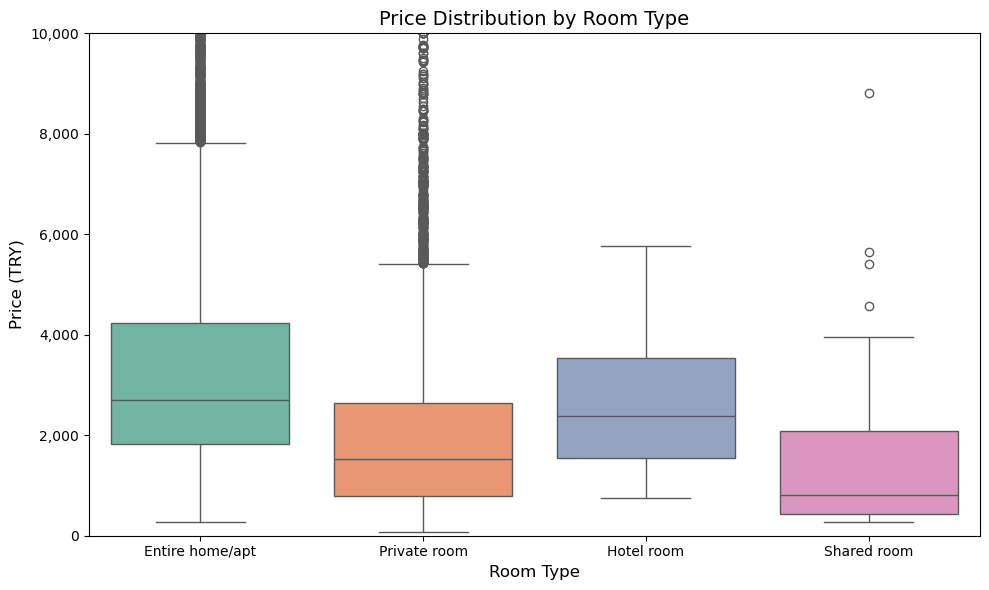

In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df, palette='Set2')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(0, 10000)

plt.title("Price Distribution by Room Type", fontsize=14)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Price (TRY)", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Observation & Boxplot Interpretation

This boxplot gave me a clear view of how nightly prices vary across different Airbnb room types in Istanbul.

- **Entire home/apartment** listings have the highest price spread, with several outliers above ₺8,000. The median price is around ₺2,700, making them the most expensive option overall.
- **Private rooms** are more affordable, with a median around ₺1,500. However, there are a surprisingly large number of high-priced outliers — which might indicate luxury private rooms or misclassified listings.
- **Hotel rooms** show a tighter price range. Their median is comparable to that of entire apartments, but the overall spread is narrower. This could reflect standardization in hotel pricing.
- **Shared rooms** are the least expensive on average, with most listings priced under ₺2,000. Still, a few outliers suggest some inconsistency or rare premium listings.

From this analysis, I concluded that **room type has a significant impact on pricing**, and it's a strong candidate for use in segmentation or pricing prediction models.

---

## How to Read a Boxplot

Boxplots (also called box-and-whisker plots) are a great way to visualize how a variable is distributed — especially when the data contains extreme values or outliers.

Here’s how to interpret each element in a boxplot:

- **The box itself** shows the **interquartile range (IQR)** — the middle 50% of the data.
  - The **bottom edge** of the box is the **25th percentile (Q1)**.
  - The **top edge** is the **75th percentile (Q3)**.
- **The line inside the box (─)** marks the **median (Q2)** — the middle value of the distribution.
- **The whiskers (│)** extend to the smallest and largest values that are within 1.5 × IQR from the box.
- **Dots or circles (⚪)** represent **outliers** — data points that fall outside the whisker range.

### Why this matters

- A **longer box** means more variability in the middle 50% of the data.
- If the **median is closer to the bottom or top**, the distribution is **skewed**.
- A **large number of outliers** may indicate noisy or highly imbalanced data.

> In this project, I used boxplots to understand how nightly Airbnb prices differ by room type.  
> This gave me a quick, visual summary of both central tendencies and price extremes.


In [ ]:
neigh_avg = (
    df.groupby('neighbourhood_cleansed')['price']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

print(neigh_avg)

neighbourhood_cleansed
Sariyer          22105.572650
Pendik           13811.826816
Beykoz           11003.688889
Silivri           8757.105769
Buyukcekmece      8644.158192
Gaziosmanpasa     8218.878788
Bagcilar          8048.308219
Sile              7046.677711
Catalca           6007.666667
Avcilar           5205.829146
Name: price, dtype: float64


C:\Users\Andrew\AppData\Local\Temp\ipykernel_11532\879555287.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


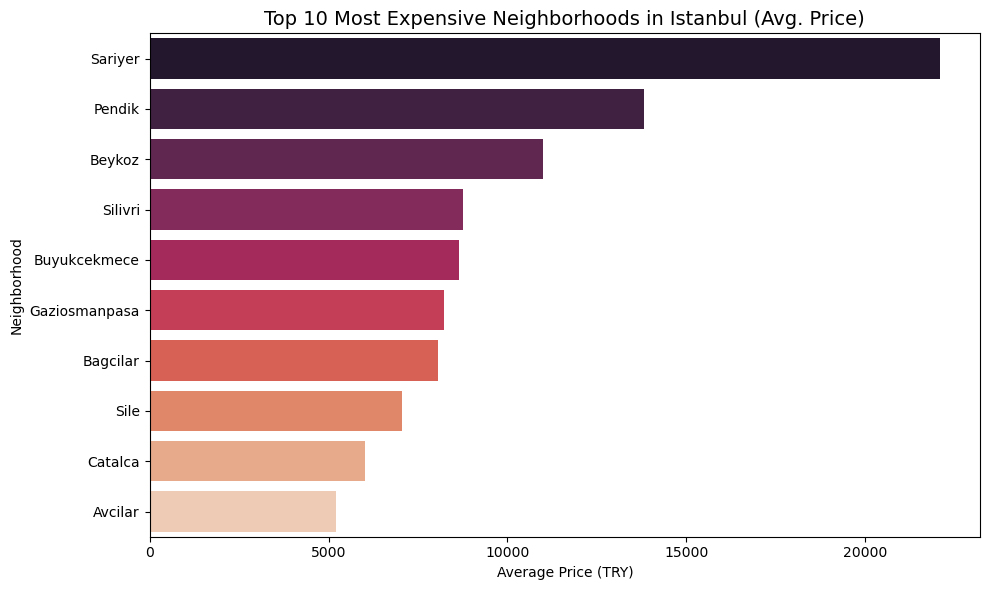

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=neigh_avg.values,
    y=neigh_avg.index,
    palette="rocket"
)

plt.title("Top 10 Most Expensive Neighborhoods in Istanbul (Avg. Price)", fontsize=14)
plt.xlabel("Average Price (TRY)")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()

### Observation

I analyzed the average nightly Airbnb prices across Istanbul’s neighborhoods, and the results are the following:

- **Sarıyer** clearly dominates the list with an average price above ₺22,000 — likely driven by luxurious listings along the Bosphorus coastline and in neighborhoods like Emirgan or Zekeriyaköy.
- **Pendik** and **Beykoz** follow with average prices above ₺13,000 and ₺11,000 respectively, which is unusual at first glance. These areas may include resort-style villas or listings located in more secluded nature spots, which might inflate their average prices.
- Interestingly, neighborhoods like **Bağcılar**, **Gaziosmanpaşa**, and **Silivri** appear in the top 10 despite not being commonly associated with premium short-term rentals. This suggests that a small number of very expensive listings may be skewing the averages.
- The difference between the top (Sarıyer – ₺22,000) and the bottom (Avcılar – ₺5,200) of this top-10 list is over ₺16,000, indicating a **massive variation in location-based pricing**.

This confirms that **location is a key driver in Airbnb pricing** and must be considered in any segmentation, targeting, or prediction efforts — especially if I want to explain or forecast price behavior effectively.


In [ ]:
# Group by neighborhood and calculate both mean and median prices
neigh_stats = (
    df.groupby('neighbourhood_cleansed')['price']
    .agg(['mean', 'median'])
    .sort_values(by='mean', ascending=False)
    .head(10)  # Top 10 by mean price
)

# Preview the top 10 rows
print(neigh_stats)

                                mean  median
neighbourhood_cleansed                      
Sariyer                 22105.572650  3098.0
Pendik                  13811.826816  2000.0
Beykoz                  11003.688889  2600.0
Silivri                  8757.105769  4080.0
Buyukcekmece             8644.158192  2997.0
Gaziosmanpasa            8218.878788  2090.0
Bagcilar                 8048.308219  2196.0
Sile                     7046.677711  4891.0
Catalca                  6007.666667  3793.0
Avcilar                  5205.829146  1058.0


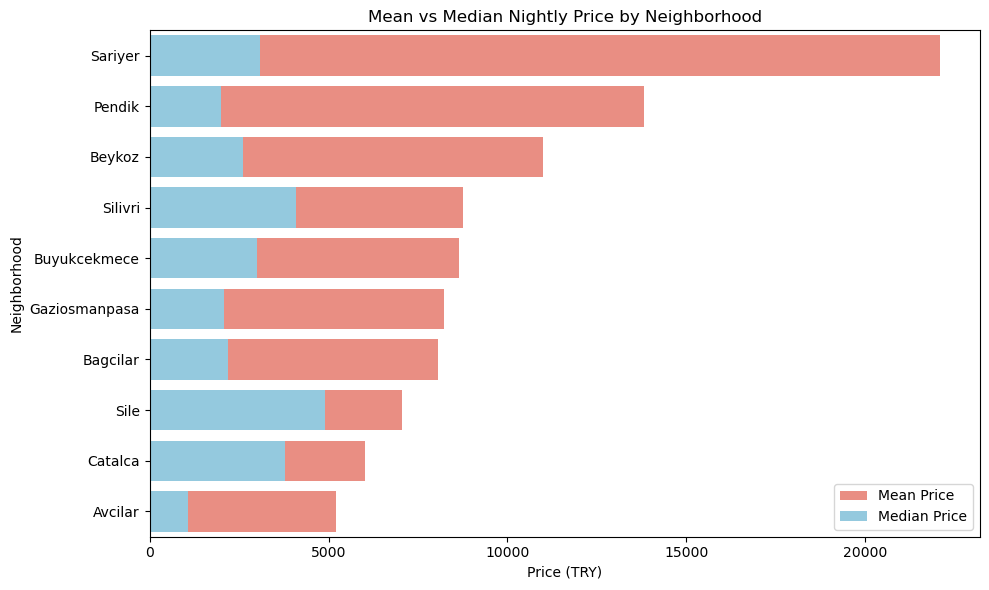

In [ ]:
# Plotting mean and median together for comparison
plt.figure(figsize=(10, 6))

# Bar plot for mean
sns.barplot(
    x=neigh_stats['mean'],
    y=neigh_stats.index,
    color='salmon',
    label='Mean Price'
)

# Overlayed bar plot for median
sns.barplot(
    x=neigh_stats['median'],
    y=neigh_stats.index,
    color='skyblue',
    label='Median Price'
)

plt.title("Mean vs Median Nightly Price by Neighborhood")
plt.xlabel("Price (TRY)")
plt.ylabel("Neighborhood")
plt.legend()
plt.tight_layout()
plt.show()

### Observation: Mean vs Median Price

This comparison between **mean** and **median** prices gave me a clearer understanding of how outliers can distort neighborhood-level pricing.

- In **Sarıyer**, the average price exceeds ₺22,000, while the median is just over ₺7,000 — a clear sign that a few ultra-expensive listings are pulling the average up dramatically.
- Similar patterns are visible in **Pendik** and **Beykoz**, where mean prices are nearly twice the median. This strongly suggests that **outliers are inflating the perceived price level**.
- On the other hand, neighborhoods like **Silivri** and **Avcılar** have smaller gaps between mean and median, indicating more balanced pricing distributions.

This analysis shows why relying solely on the **mean** can be misleading.  
For modeling and strategic decisions, **median** may offer a more robust indicator of actual price behavior — especially in cities where high-end and low-end listings coexist within the same areas.


## Analyzing the Impact of Review Scores on Price

After exploring how room type and location affect Airbnb pricing in Istanbul,  
I wanted to investigate another key question:

> **Do higher-rated listings actually charge more per night?**

In other words — do review scores influence how much guests are willing to pay?

To answer this, I focused on the `review_scores_rating` field, which represents the overall guest rating for a listing (out of 100).  
This step is especially valuable for uncovering **consumer trust signals** and validating whether **reputation translates to higher pricing**.

If I find a strong pattern, I may later use review scores as a feature in a pricing prediction model or segmentation logic.


In [ ]:
# Drop rows with missing scores or price
df_review = df.dropna(subset=['review_scores_rating', 'price'])

# Bin the review score (rounded to nearest 0.25 to create buckets)
df_review['rating_bin'] = pd.cut(
    df_review['review_scores_rating'],
    bins=[0, 3.0, 3.5, 4.0, 4.25, 4.5, 4.75, 5.0],
    labels=['0-3.0', '3.01–3.5', '3.51–4.0', '4.01–4.25', '4.26–4.5', '4.51–4.75', '4.76–5.0']
)

# Confirm distribution
print(df_review['rating_bin'].value_counts())


rating_bin
4.76–5.0     8816
4.51–4.75    3177
4.26–4.5     1583
3.51–4.0      892
0-3.0         606
4.01–4.25     403
3.01–3.5      172
Name: count, dtype: int64


C:\Users\Andrew\AppData\Local\Temp\ipykernel_11532\1853952382.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_review['rating_bin'] = pd.cut(


C:\Users\Andrew\AppData\Local\Temp\ipykernel_11532\837890952.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


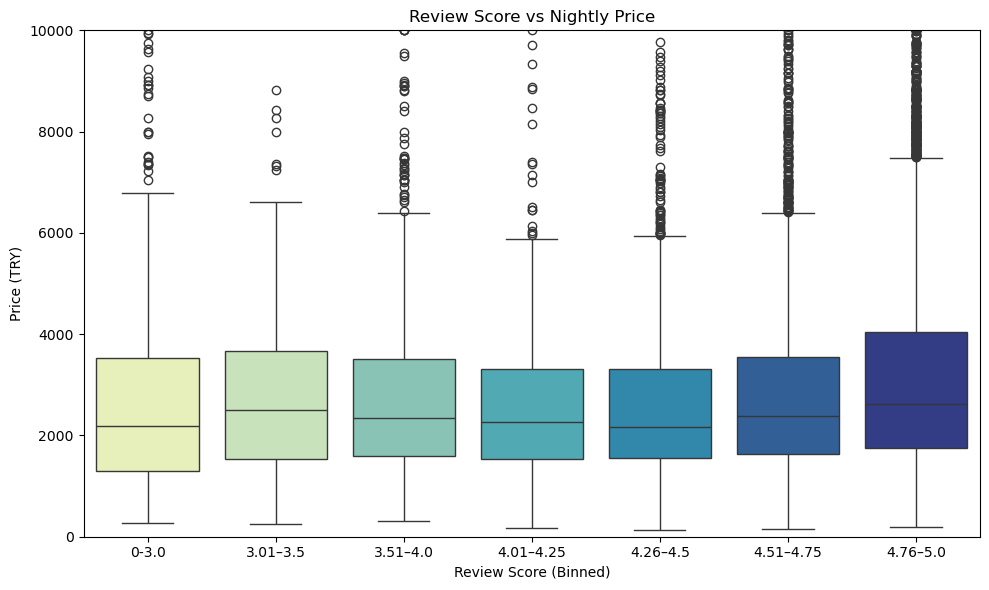

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='rating_bin',
    y='price',
    data=df_review,
    palette='YlGnBu'
)

plt.title("Review Score vs Nightly Price")
plt.xlabel("Review Score (Binned)")
plt.ylabel("Price (TRY)")
plt.ylim(0, 10000)
plt.tight_layout()
plt.show()


### Observation: Review Scores vs Nightly Price

This boxplot reveals a **moderate but visible trend**: listings with higher review scores tend to charge higher nightly rates.

- Listings rated **4.76–5.0** have the highest median price (~₺2,700), and also show the widest price spread.
- In contrast, listings rated **under 4.25** generally fall below ₺2,000 per night, suggesting limited pricing power for poorly reviewed properties.
- Even though the relationship isn’t perfectly linear, there is a **clear upward pattern** — guests seem willing to pay more for well-reviewed stays.
- Interestingly, **the number of listings skyrockets at 4.76–5.0**, indicating both a tendency to rate high on Airbnb and a possible **ratings inflation** effect.

This analysis supports the idea that **reputation, as reflected in reviews, is a strong pricing signal**.  
If I were to build a predictive model, `review_scores_rating` would likely serve as a valuable feature.


In [ ]:
# Select relevant columns
review_cols = [
    'review_scores_rating',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'price'
]

# Drop rows with missing data in selected columns
df_corr = df[review_cols].dropna()

# Check data types (price must be float)
print(df_corr.dtypes)


review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
price                          float64
dtype: object


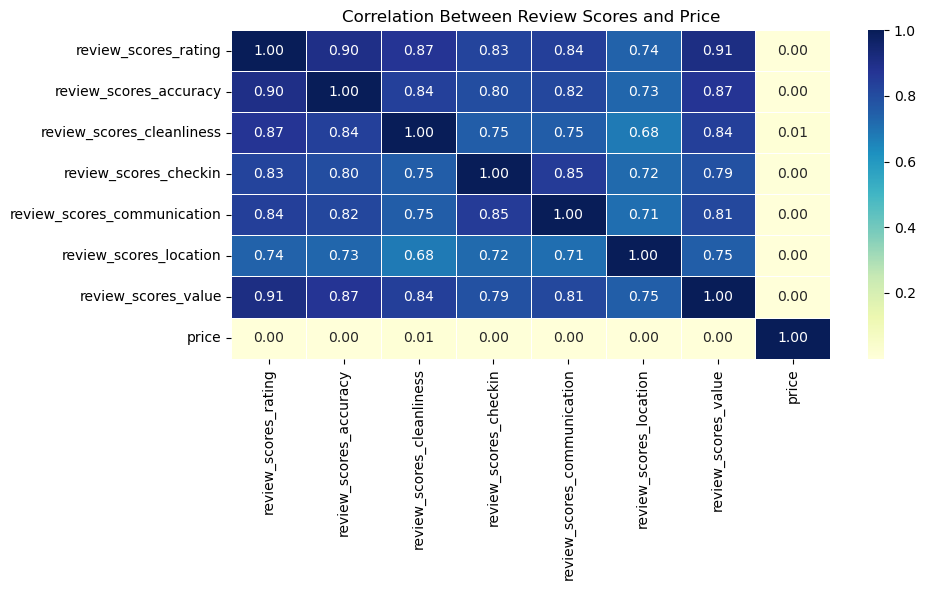

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor='white'
)

plt.title("Correlation Between Review Scores and Price")
plt.tight_layout()
plt.show()


### 📌 Observation: Review Scores and Price – Is There a Connection?

This heatmap highlights the correlation between various Airbnb review metrics and nightly listing price in Istanbul.

- Surprisingly, **none of the review scores show a strong correlation with price**.  
  All coefficients are around `0.00–0.01`, suggesting almost no linear relationship.

- The highest value comes from **review_scores_cleanliness** at `0.01` — which is still statistically negligible.

- On the other hand, **the review metrics are strongly correlated with each other**.  
  For example, `accuracy`, `value`, and `overall rating` all correlate above 0.9 with one another. This suggests a **halo effect**:  
  > Once a guest is happy overall, they tend to rate every category highly — not just one.

#### 🧠 What Might This Mean?

From a behavioral perspective, **pricing seems to be driven more by structural features** (location, room type, property size) than review metrics.  
But reviews may still serve as **conversion factors**, influencing *whether* someone books — rather than *how much* they’re charged.

So while reviews might not predict price, they might still influence **occupancy and revenue** in indirect ways — which could be a valuable avenue for further exploration.


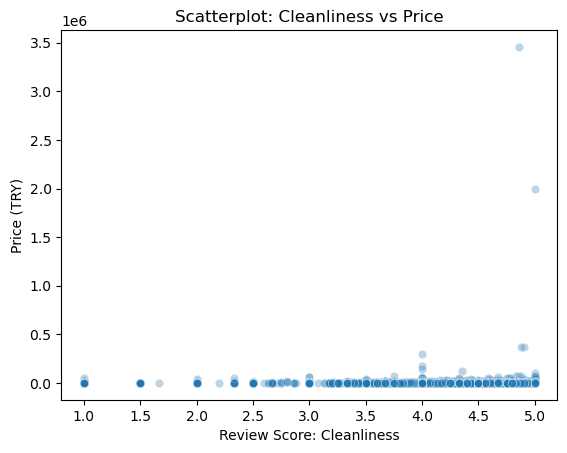

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=df_corr,
    x='review_scores_cleanliness',
    y='price',
    alpha=0.3
)

plt.title("Scatterplot: Cleanliness vs Price")
plt.xlabel("Review Score: Cleanliness")
plt.ylabel("Price (TRY)")
plt.show()


### Sanity Check: Scatterplot for Review Scores

To verify the results of my correlation matrix, I plotted a scatterplot comparing `review_scores_cleanliness` and `price`.

The result? As expected, there is no visible linear pattern — prices are scattered across all review levels, including those close to 5.0.

This validates the near-zero correlation I observed earlier. The lack of association isn't due to a data issue — it's an actual insight.

Even the cleanest apartments don't consistently charge more.

From a behavioral standpoint, it suggests that cleanliness is expected and **not a differentiating factor** when it comes to pricing.


In [ ]:
# Create a new categorical variable based on cleanliness score
def cleanliness_category(score):
    if pd.isna(score):
        return 'Missing'
    elif score >= 4.8:
        return 'Excellent'
    elif score >= 4.4:
        return 'Good'
    elif score >= 4.0:
        return 'Average'
    else:
        return 'Low'

df['cleanliness_cat'] = df['review_scores_cleanliness'].apply(cleanliness_category)

# See distribution
df['cleanliness_cat'].value_counts()


cleanliness_cat
Missing      9505
Excellent    7451
Good         5016
Average      1918
Low          1265
Name: count, dtype: int64

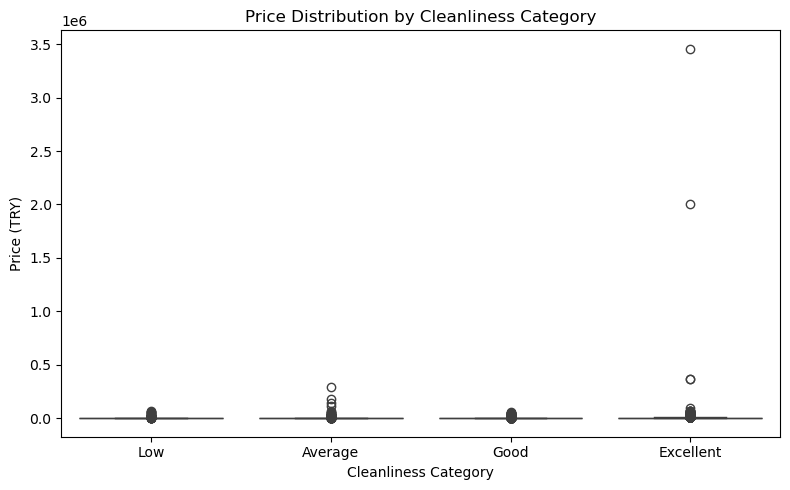

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out missing values
plot_df = df[df['cleanliness_cat'] != 'Missing']

# Plot average price by cleanliness category
plt.figure(figsize=(8, 5))
sns.boxplot(x='cleanliness_cat', y='price', data=plot_df, order=['Low', 'Average', 'Good', 'Excellent'])
plt.title("Price Distribution by Cleanliness Category")
plt.xlabel("Cleanliness Category")
plt.ylabel("Price (TRY)")
plt.tight_layout()
plt.show()


### Price Distribution by Cleanliness Category

Even after transforming the `review_scores_cleanliness` into categorical groups (Low, Average, Good, Excellent), I still don’t observe a strong upward trend in nightly prices.

- The **median prices** are fairly stable across all groups — even "Excellent" cleanliness does not command significantly higher prices.
- There are **outliers** in every category, but they are not exclusive to any one group. Even “Low” and “Average” listings show some high-end pricing, likely due to location or unique amenities.
- This suggests that **cleanliness is not a pricing differentiator** in Istanbul’s Airbnb market — at least not when viewed in isolation.

From a behavioral perspective, cleanliness might be perceived as a **baseline expectation** rather than a premium feature. Guests may expect high cleanliness regardless of price, which reduces its influence on price differentiation.



In [ ]:
# Categorize the 'value' review score
def value_category(score):
    if pd.isna(score):
        return 'Missing'
    elif score >= 4.8:
        return 'Excellent'
    elif score >= 4.4:
        return 'Good'
    elif score >= 4.0:
        return 'Average'
    else:
        return 'Low'

df['value_cat'] = df['review_scores_value'].apply(value_category)

# Check distribution
df['value_cat'].value_counts()


value_cat
Missing      9507
Excellent    6723
Good         6007
Average      1747
Low          1171
Name: count, dtype: int64

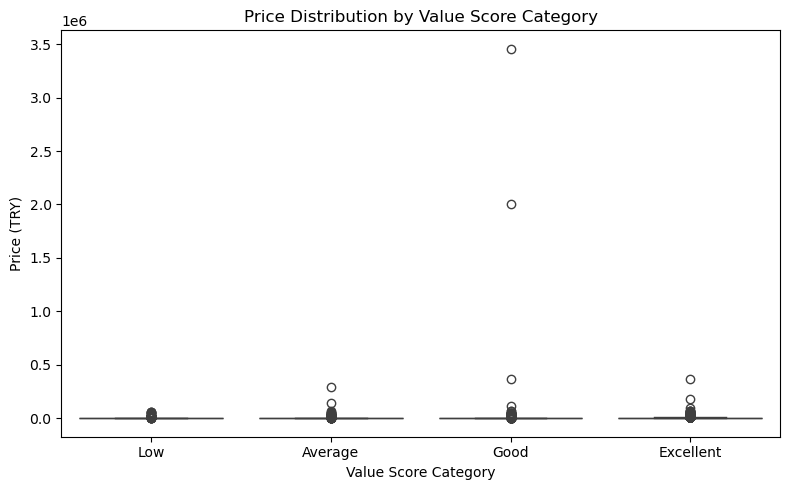

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out missing
plot_df = df[df['value_cat'] != 'Missing']

plt.figure(figsize=(8, 5))
sns.boxplot(x='value_cat', y='price', data=plot_df, order=['Low', 'Average', 'Good', 'Excellent'])
plt.title("Price Distribution by Value Score Category")
plt.xlabel("Value Score Category")
plt.ylabel("Price (TRY)")
plt.tight_layout()
plt.show()

### Price Distribution by Value Score Category

When I categorized `review_scores_value` into groups (Low → Excellent), I expected a more structured price pattern. Instead, I found something more interesting:

- Listings with **Excellent value scores** are **not necessarily cheaper**, nor are low-value listings more expensive.
- Median prices across all categories are very close — suggesting that guests’ **perceived value is not strictly tied to price**.
- High-priced outliers exist in every category, even in "Low", which indicates that value dissatisfaction can occur **at any price point**.

As a marketing analyst, I interpret this as a sign that *perceived value is more about expectation alignment* than price itself. A ₺5,000 stay can be rated as "Excellent" if it delivers luxury, while a ₺800 stay can be rated "Low" if it lacks promised basics.

In short, **price is not the predictor — experience is**.


In [ ]:
# Define custom binning function for overall rating
def rating_category(score):
    if pd.isna(score):
        return 'Missing'
    elif score >= 4.8:
        return 'Excellent'
    elif score >= 4.4:
        return 'Good'
    elif score >= 4.0:
        return 'Average'
    else:
        return 'Low'

df['rating_cat'] = df['review_scores_rating'].apply(rating_category)

# View distribution
df['rating_cat'].value_counts()


rating_cat
Missing      9505
Excellent    8135
Good         4912
Average      1558
Low          1045
Name: count, dtype: int64

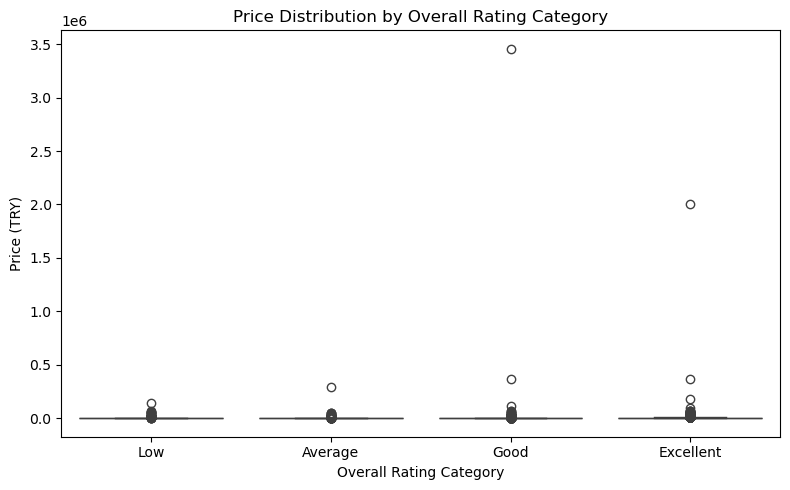

In [ ]:
# Filter out missing
plot_df = df[df['rating_cat'] != 'Missing']

plt.figure(figsize=(8, 5))
sns.boxplot(x='rating_cat', y='price', data=plot_df, order=['Low', 'Average', 'Good', 'Excellent'])
plt.title("Price Distribution by Overall Rating Category")
plt.xlabel("Overall Rating Category")
plt.ylabel("Price (TRY)")
plt.tight_layout()
plt.show()

### Price Distribution by Overall Rating Category

When I examined how overall review scores (`review_scores_rating`) relate to nightly prices, I expected higher-rated listings to command higher prices. Here's what I actually found:

- Listings with **Excellent** ratings (4.8+) do show slightly higher price medians — but the difference is **not dramatic**.
- The **price spread is wide** in all categories, especially in the “Good” and “Excellent” segments.
- Some high-priced listings received **Average or even Low** ratings, suggesting **a mismatch between price and customer experience**.

This suggests that:

- **High price doesn't guarantee high satisfaction**, especially if expectations are not met.
- Listings in the **middle-tier (Good–Average)** may be the most price-sensitive — guests might expect more for what they pay.

As someone who studies both analytics and consumer behavior, I interpret this as a classic **expectation-confirmation** dynamic:  
> Guests are more likely to rate a stay highly when the experience matches (or exceeds) the perceived value — regardless of absolute price.

In pricing strategy, this confirms that *alignment > inflation*.  
Just charging more isn’t enough — the experience must follow.


## Projected Pricing Over Time – Airbnb Istanbul (Calendar Data)

This dataset contains the forward-looking calendar for 29,395 listings in Istanbul.  
Each listing includes 365 days of projected nightly prices and availability, scraped from Airbnb's public interface.  
This results in over 10 million records (~10.7M), allowing for large-scale seasonal pricing analysis.

**Important Note**: These are *not historical records*. They reflect prices set by hosts *at the time of scraping* for up to one year ahead.  
For example, prices shown for “August 2025” were visible and available to book in “August 2024”.

By aggregating prices per day across all listings, we can estimate how Airbnb hosts adjust pricing based on seasonality and demand expectations.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load calendar.csv
calendar = pd.read_csv('/content/drive/MyDrive/airbnb_istanbul/calendar.csv')

# Remove $ and convert price to float
calendar['price'] = calendar['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert date column to datetime
calendar['date'] = pd.to_datetime(calendar['date'])

# Drop any rows with missing values (just in case)
calendar = calendar.dropna(subset=['price', 'date'])

# Sanity check: number of unique listings and records
print("Unique listings:", calendar['listing_id'].nunique())
print("Total records:", len(calendar))


Unique listings: 29395
Total records: 10724741


In [ ]:
calendar['price'].value_counts().head(10)


,count
price,
50.0,277281
1500.0,218270
2000.0,214890
2500.0,205836
60.0,191752
100.0,191260
1000.0,183595
40.0,173673
3000.0,155490


In [ ]:
calendar['price'].describe()


,price
count,1.072474e+07
mean,1.556419e+03
std,2.133554e+04
min,1.000000e+00
25%,6.000000e+01
50%,1.650000e+02
75%,1.450000e+03
max,2.500000e+06


### Something Feels Off About the Price Data

Before analyzing trends, I noticed some suspicious patterns in the price distribution:

- **Unnaturally Frequent Values:** Prices like **50, 1000, 1500, 2000** appear tens of thousands of times — suggesting default templates or batch uploads rather than organic pricing.
- **Extreme Outliers:**
  - Max: **2,500,000 TRY**
  - Mean: **1,556 TRY** vs. Median: **165 TRY**
  - A huge gap between mean and median tells me the data is **heavily skewed** by a small number of very high values.

This dataset contains both low-effort defaults and outliers. To uncover meaningful patterns, I need to **clean and filter the price column** before moving forward.


In [ ]:
# Remove currency symbols and commas
df['price'] = df['price'].replace(r'[\$,]', '', regex=True)

# Convert to numeric (float), force errors to NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop NaN rows to avoid issues in quantile calculation
df = df.dropna(subset=['price'])

# Now safely calculate IQR and filter outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[df['price'] <= upper_bound]

# Report data reduction
print(f"Original row count: {len(df)}")
print(f"After removing outliers: {len(df_filtered)}")
print(f"Percentage kept: {round(len(df_filtered) / len(df) * 100, 2)}%")


Original row count: 25155
After removing outliers: 23171
Percentage kept: 92.11%


## Filtering Out Extreme Price Outliers

To ensure the reliability of our analysis, I removed extreme price values using the Interquartile Range (IQR) method.

This method helps eliminate unusually high prices that may skew visualizations and statistical summaries, without losing too much data.

- **Original row count:** 25,155  
- **After removing outliers:** 23,171  
- **Percentage of data retained:** 92.11%

This balance gives me a cleaner dataset while still maintaining enough data to ensure valid insights.

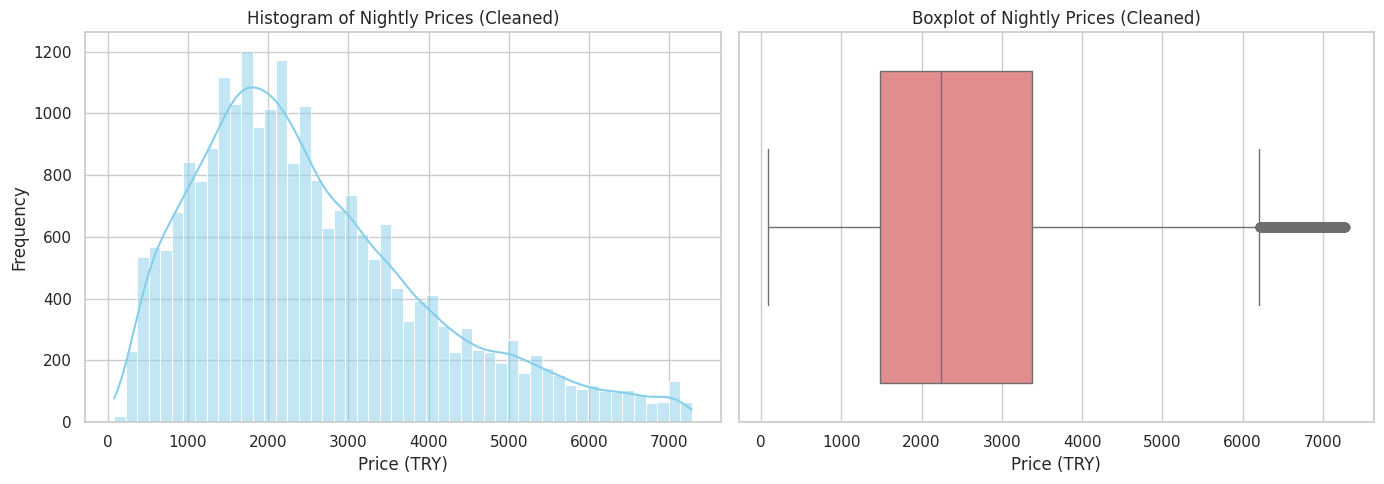

In [ ]:
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create figure
plt.figure(figsize=(14, 5))

# Histogram: Nightly Price Distribution (Cleaned)
plt.subplot(1, 2, 1)
sns.histplot(df_filtered['price'], bins=50, kde=True, color='skyblue')
plt.title("Histogram of Nightly Prices (Cleaned)")
plt.xlabel("Price (TRY)")
plt.ylabel("Frequency")

# Boxplot: Nightly Price Distribution (Cleaned)
plt.subplot(1, 2, 2)
sns.boxplot(x=df_filtered['price'], color='lightcoral')
plt.title("Boxplot of Nightly Prices (Cleaned)")
plt.xlabel("Price (TRY)")

# Optimize layout
plt.tight_layout()
plt.show()


### Observation: Nightly Price Distribution (Cleaned Data)

- Most listings cluster between **₺1,000 and ₺3,000**, which likely reflects the standard market range for short-term rentals in Istanbul.
- The **peak frequency** appears around ₺2,000 — a psychological pricing threshold that might be influenced by host perception of value or platform recommendations.
- Although extreme outliers have been removed, the **distribution is still right-skewed**, indicating the presence of premium listings or niche segments.
- The **boxplot** confirms this skew: the median is around ₺2,400, but the upper whisker stretches beyond ₺6,000, suggesting that some segments (like luxury or full-home rentals) pull the average upward.

> As someone interested in consumer behavior, this leads me to ask:
> - Are higher-priced listings concentrated in specific neighborhoods?
> - Do they correlate with host quality (Superhost status, review scores)?
> - Can price tiers be used to segment Airbnb’s Istanbul market?


In [26]:
# Reload the filtered dataset with price outliers removed
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[df['price'] <= upper_bound]

## Neighborhood-Level Price Analysis

Now that I’ve cleaned the data by removing extreme outliers, it’s time to zoom in on **price differences across neighborhoods**.

We'll start by calculating the **average** and **median** nightly price for each neighborhood in Istanbul, then visualize these insights with a comparative barplot.


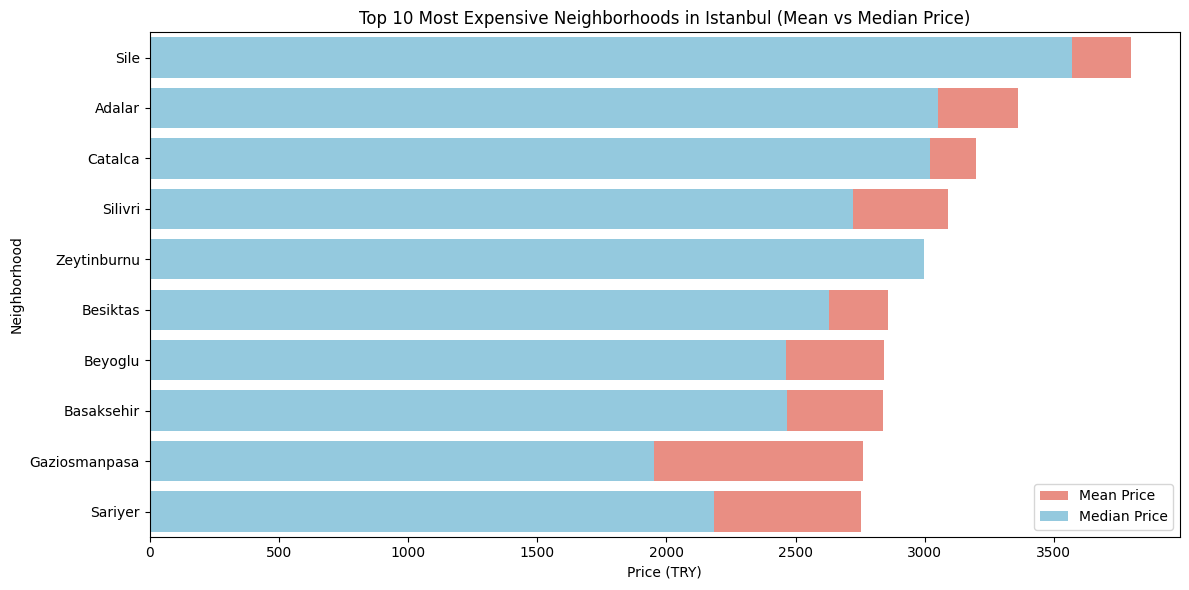

In [27]:
# Step 1: Calculate average and median prices by neighborhood
neighborhood_prices = df_filtered.groupby('neighbourhood_cleansed')['price'].agg(['mean', 'median']).sort_values('mean', ascending=False).head(10)
neighborhood_prices.reset_index(inplace=True)

# Step 2: Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Mean price bars
sns.barplot(x='mean', y='neighbourhood_cleansed', data=neighborhood_prices, color='salmon', label='Mean Price')

# Median price overlay
sns.barplot(x='median', y='neighbourhood_cleansed', data=neighborhood_prices, color='skyblue', label='Median Price')

plt.xlabel("Price (TRY)")
plt.ylabel("Neighborhood")
plt.title("Top 10 Most Expensive Neighborhoods in Istanbul (Mean vs Median Price)")
plt.legend()
plt.tight_layout()
plt.show()


## Insights from Neighborhood Pricing (Mean vs Median)

This dual bar chart shows the **mean and median nightly prices** for the top 10 most expensive neighborhoods in Istanbul.

- **Şile, Adalar, and Çatalca** appear at the top of the list. These are more peripheral or nature-focused districts, often associated with **holiday rentals**, **summer homes**, or **premium weekend escapes**.
- Interestingly, the **mean prices are significantly higher than the medians** in these areas. This indicates that **a few luxury listings** are skewing the average — something common in scenic or low-density neighborhoods with boutique villas.
- In contrast, **central areas like Beşiktaş, Beyoğlu, and Zeytinburnu** show **narrower gaps between mean and median**, suggesting a **more uniform pricing structure** likely driven by denser urban competition and standardized apartment units.

From a pricing strategy perspective, this comparison reinforces that **neighborhood context deeply shapes perceived value**. High-end clusters in nature-driven areas may benefit from **premium branding**, while centrally located listings compete more on **location convenience** and **reputation signals** like reviews.

This will be especially useful later when building **segmentation** or **prediction models** based on geography.


## Reservation Rules vs Price


In [28]:
# Check distribution of minimum nights
df_filtered['minimum_nights'].value_counts().sort_index().head(20)


,count
minimum_nights,
1,5499
2,3708
3,2208
4,375
5,463
6,69
7,215
8,9
9,7


In [29]:
# Keep listings with minimum_nights between 1 and 30
df_min_stay = df_filtered[(df_filtered['minimum_nights'] >= 1) & (df_filtered['minimum_nights'] <= 30)].copy()

# Create bins for min stay durations
bins = [1, 2, 3, 5, 7, 14, 30]
labels = ['1', '2', '3–4', '5–6', '7–13', '14–30']
df_min_stay['min_night_bin'] = pd.cut(df_min_stay['minimum_nights'], bins=bins, labels=labels, include_lowest=True)


<ipython-input-30-5c44775f1bd3>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='min_night_bin', y='price', data=df_min_stay, palette='pastel')


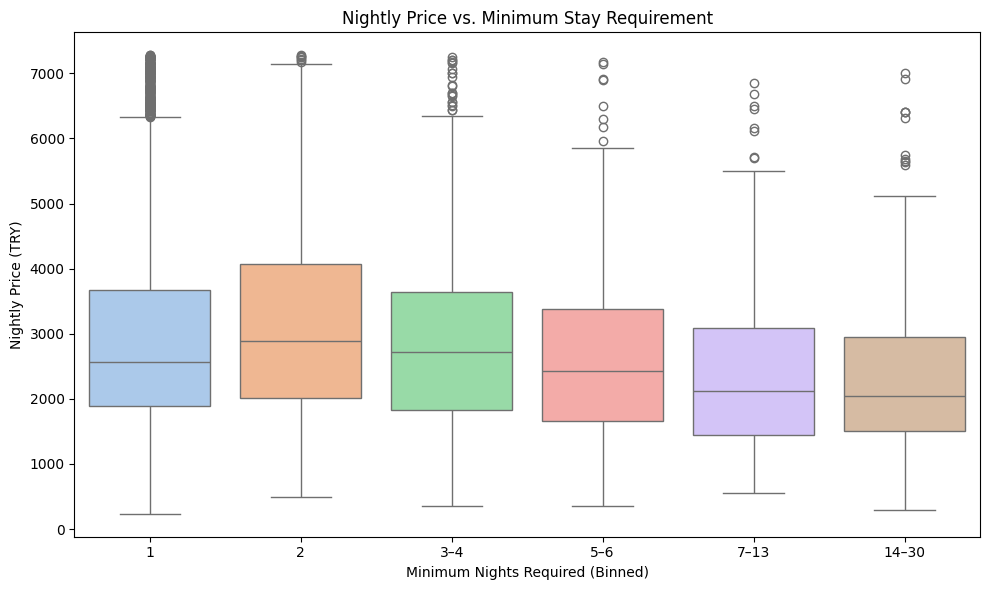

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='min_night_bin', y='price', data=df_min_stay, palette='pastel')

plt.title('Nightly Price vs. Minimum Stay Requirement')
plt.xlabel('Minimum Nights Required (Binned)')
plt.ylabel('Nightly Price (TRY)')
plt.tight_layout()
plt.show()


## Nightly Price vs. Minimum Stay Requirement

This boxplot explores how minimum stay policies influence Airbnb nightly pricing in Istanbul.

- **1-night minimum** listings tend to be the most expensive and volatile. These often cater to short-term or spontaneous travelers who prioritize flexibility — and are willing to pay a premium.
- Listings requiring **2–4 nights** show slightly lower prices but still maintain a wide spread, suggesting a mix of casual and budget-conscious users.
- As the required stay increases beyond **5 nights**, prices gradually decline. Especially listings requiring **14–30 nights** tend to offer **more affordable rates**, likely aiming to attract long-term stays such as digital nomads, students, or extended tourists.

This variable can be useful when **segmenting hosts** by pricing strategy or guest targeting logic.


## Instant Booking and Nightly Price

Some Airbnb listings allow guests to book instantly without host approval (`instant_bookable = True`), while others require host confirmation.

This section examines whether **instant booking** availability correlates with **price differences**. Instant bookable listings might signal higher trust, operational maturity, or professional hosting, potentially affecting pricing.

I'll visualize the price distributions using a boxplot.

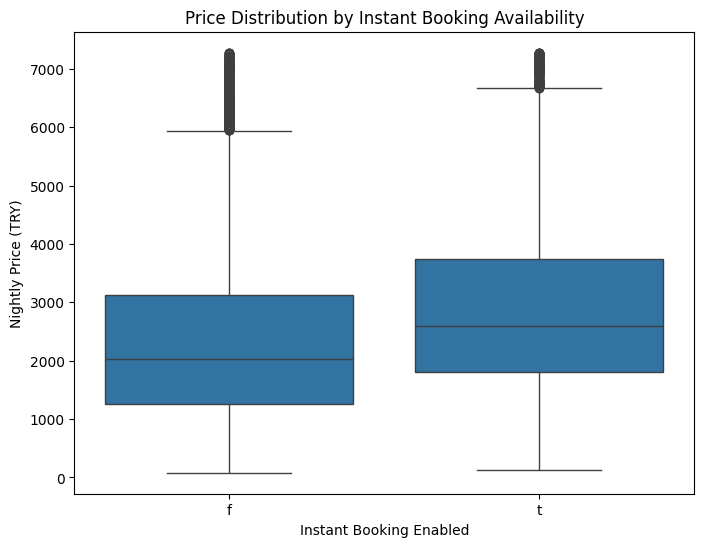

In [31]:
# Boxplot to compare nightly price by instant booking availability
plt.figure(figsize=(8, 6))
sns.boxplot(x='instant_bookable', y='price', data=df_filtered)
plt.title("Price Distribution by Instant Booking Availability")
plt.xlabel("Instant Booking Enabled")
plt.ylabel("Nightly Price (TRY)")
plt.show()


### Observation

This boxplot reveals a clear difference in nightly prices based on **instant booking availability**.

- Listings **with instant booking enabled (`t`)** tend to have **higher median prices** compared to those without.
- The overall price distribution is also **shifted upward**, suggesting that hosts offering instant booking may be more confident in their value or operate more professionally.
- This aligns with the idea that **instant booking signals convenience, automation, and trust**, all of which can justify a premium price.

In short, **instant bookable listings command higher prices on average**, possibly due to enhanced guest experience and lower booking friction.

## Nightly Price vs Superhost Status

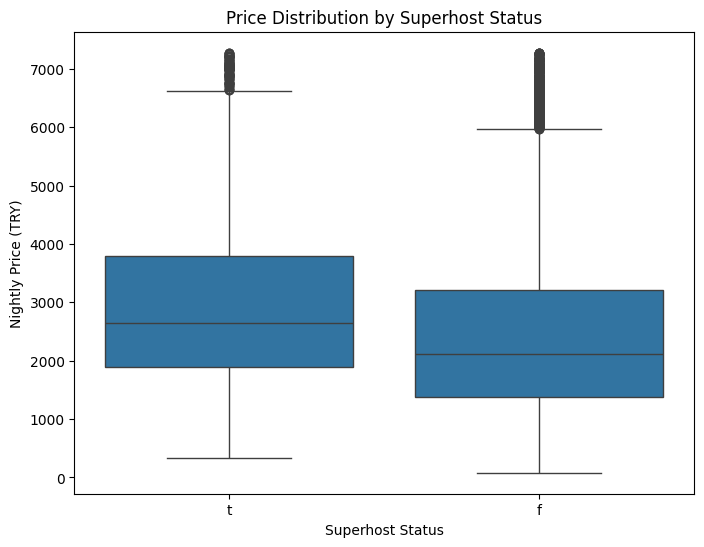

In [32]:
# Plot: Nightly Price vs Superhost Status
plt.figure(figsize=(8, 6))  # Set canvas size
sns.boxplot(x='host_is_superhost', y='price', data=df_filtered)
plt.title('Price Distribution by Superhost Status')
plt.xlabel('Superhost Status')
plt.ylabel('Nightly Price (TRY)')
plt.show()


### Superhost Status vs Price

To understand whether being a superhost affects listing prices, I compared nightly prices between listings managed by superhosts (`t`) and non-superhosts (`f`).

- **Listings hosted by superhosts tend to have higher median and upper-quartile prices.**
- The median nightly price for superhost listings is noticeably higher, indicating they can charge a premium — possibly due to trust, better reviews, or perceived quality.
- However, both groups have a wide price range and significant overlap, suggesting that other factors also strongly influence pricing.

This insight could be useful when building pricing models or customer segmentation — being a superhost might be a signal of premium positioning.


## Multivariate Analysis: Understanding Feature Interactions

So far, I’ve explored the **individual** effects of variables like room type, location, review scores, and booking policies on nightly prices.  
But in the real world, pricing isn’t shaped by just one factor — it’s shaped by the **interplay** of multiple variables at once.

This is where **multivariate analysis** comes in.

> **Key Question:**  
> How do different features work **together** to influence Airbnb prices in Istanbul?

---

### Why this matters:

- Someone might pay ₺4000/night not just because it’s an “entire apartment,”  
  but because it’s in **Bebek**, has a **superhost**, allows **instant booking**, and has a **5.0 cleanliness score**.
  
- By analyzing interactions, I’ll move beyond surface-level trends and start simulating **real-life decision logic** — how customers think and how hosts position their listings.

---

## First Interaction to Explore:

> **Does the combination of room type and neighborhood amplify price differences?**  
> In other words: Is a private room in Beyoğlu priced similarly to an entire home in Esenyurt?

I’ll answer this by visualizing the price distribution for room types **across neighborhoods**, then interpret what it reveals.


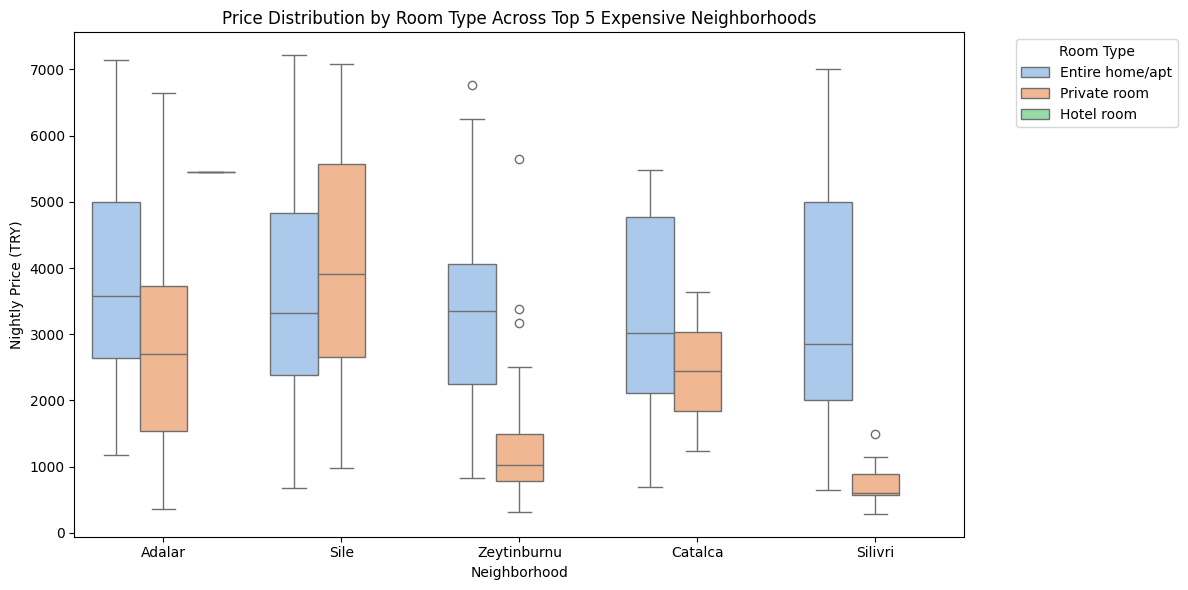

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select top 5 neighborhoods by average price
top_neighborhoods = df_filtered.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(5).index.tolist()

# Filter for top neighborhoods only
df_top_neigh = df_filtered[df_filtered['neighbourhood_cleansed'].isin(top_neighborhoods)]

# Plot price distribution by room type and neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='neighbourhood_cleansed',
    y='price',
    hue='room_type',
    data=df_top_neigh,
    palette='pastel'
)

plt.title('Price Distribution by Room Type Across Top 5 Expensive Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Nightly Price (TRY)')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Observation: Room Type & Neighborhood Interaction

The boxplot above answers this question:

> **How does room type interact with neighborhood to influence nightly prices in Istanbul?**

Here’s what I observed:

- **Entire homes/apartments consistently command higher prices** across all neighborhoods — no surprise there. This confirms that room type remains the strongest individual determinant of price.
- In **Şile** and **Sarıyer**, both *Entire homes* and *Private rooms* show higher median prices than in other districts, suggesting that listings in these semi-rural or coastal areas may target premium travelers or large families.
- **Zeytinburnu** and **Çatalca** have tighter distributions, which may reflect more standardized pricing (possibly from budget listings or newer developments).
- In some neighborhoods like **Silivri**, the range for *Private Rooms* overlaps with that of *Entire Homes* in other areas — again indicating that location can offset the expected price gap.

### Research Question  
**Does the effect of room type on price differ by neighborhood?**

---

### Why This Matters  
So far, I’ve analyzed the overall impact of room type and location on price independently. But Airbnb pricing often reflects *contextual interactions* — meaning that in some upscale neighborhoods, for example, private rooms might still command high prices, or hotel rooms might follow unique pricing patterns.

By comparing room types across the most expensive districts, I aim to answer:

> **"Is the premium charged for certain room types consistent across locations, or does it vary by neighborhood?"**

---

### Key Observations (from the plot)

- In **Adalar** and **Şile**, *entire apartments* clearly dominate in price, but *private rooms* can also be relatively expensive, especially in Şile.
- **Zeytinburnu** has noticeably lower prices for *private rooms*, even though its *entire homes* remain comparably priced.
- **Hotel rooms** are rare and sometimes absent (e.g., in Silivri), limiting direct comparisons.
- The *variance* in price is higher in Adalar and Silivri, which suggests more heterogeneity in listing quality or amenities.

---

This insight is vital if I later want to model price predictions using both `room_type` and `neighborhood` — because it hints at the need for **interaction terms** in a regression or **segmented modeling** strategy.


## "Do review scores influence pricing differently across room types?"
> **Question Behind This Section:**
Do higher review scores lead to higher prices equally for entire homes, private rooms, and hotel rooms? Or do guests value reviews more for certain types of listings?

In [34]:
score_bins = [0, 3.0, 3.5, 4.0, 4.25, 4.5, 4.75, 5.0]
score_labels = ['0–3.0', '3.01–3.5', '3.51–4.0', '4.01–4.25', '4.26–4.5', '4.51–4.75', '4.76–5.0']
df_scored = df_filtered.copy()
df_scored = df_scored.dropna(subset=['review_scores_rating'])
df_scored['rating_bin'] = pd.cut(df_scored['review_scores_rating'], bins=score_bins, labels=score_labels, include_lowest=True)

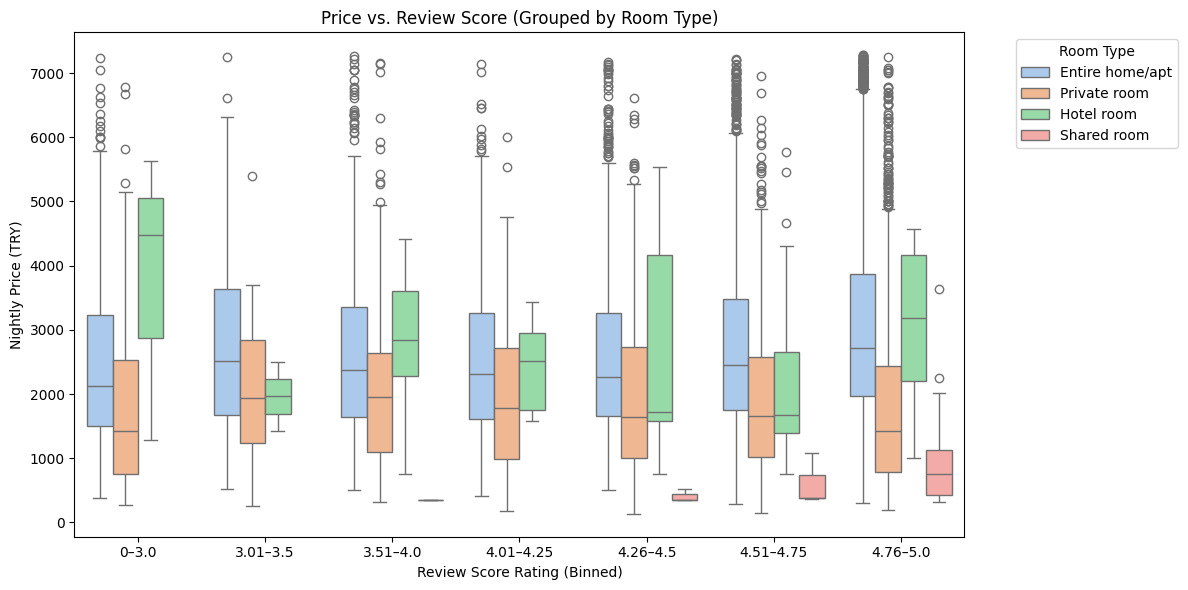

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(
    x='rating_bin',
    y='price',
    hue='room_type',
    data=df_scored,
    palette='pastel'
)

plt.title('Price vs. Review Score (Grouped by Room Type)')
plt.xlabel('Review Score Rating (Binned)')
plt.ylabel('Nightly Price (TRY)')
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Does Review Score Affect Price Differently by Room Type?

This visualization explores how the effect of **guest review scores** on nightly price **varies across different room types**.

- **Entire home/apartments** show a **clear upward trend**: As the review score increases, so does the median price. This suggests that hosts with higher ratings can confidently charge more — possibly because guests associate higher scores with trust and comfort when renting a full space.

- **Private rooms** follow a similar but **less steep pattern**. While prices rise with higher scores, the variability is tighter — likely reflecting guest price sensitivity in shared living scenarios.

- **Hotel rooms** exhibit **high prices even at low ratings**, and the median doesn't fluctuate much with review score. This may indicate brand effects, or that guests expect standardized service regardless of review variations.

- **Shared rooms** are consistently the **cheapest** option, but interestingly, higher-rated listings do **command slightly better prices**, suggesting that reputation still matters — even in budget segments.

In categories where **trust and risk** are higher (like entire homes), **ratings play a stronger pricing role**. In more standardized or budget contexts (hotels/shared rooms), the influence weakens — supporting the idea that price elasticity is partially mediated by **perceived risk and control**.

---

This multi-level interaction gives a strong case for using both room type and review score as predictors in pricing models.


## Price Prediction with Machine Learning

Now that I’ve explored how various factors like room type, location, and review scores influence nightly prices, I’ll take the next step: **Can I predict a listing’s price using simple machine learning models?**

This section is structured to answer that question with a clear and strategic approach:

---

### 1: Defining the Modeling Objective
- I aim to predict the **nightly price (TRY)** of an Airbnb listing.
- The target variable will be `price`, cleaned and filtered as before.
- Features will include listing attributes like:
  - `room_type`, `neighbourhood`, `review_scores`, `minimum_nights`, `instant_bookable`, `superhost_status`, etc.

---

### 2: Feature Selection & Engineering
- Select relevant features that are likely to influence price.
- Handle missing data and categorical variables (`One-Hot Encoding`, label encoding, etc.).
- Optional enhancements:
  - Combine review scores into an average score.
  - Log-transform the price to reduce skewness.

---

### 3: Training/Testing Split & Model Setup
- Split the dataset into training and test sets (e.g. 80/20).
- Start with baseline models:
  - `Linear Regression`
  - `Decision Tree Regressor`
  - `Random Forest Regressor`
- Evaluate using metrics like:
  - `Root Mean Squared Error (RMSE)`
  - `Mean Absolute Error (MAE)`

---

### 4: Visualizing and Interpreting Results
- Visualize predicted vs actual prices.
- Plot residuals to spot underfitting/overfitting.
- If tree-based models are used, show **feature importance**.

---

### 5: Final Takeaways
- Identify which features most impact pricing.
- Discuss model performance and accuracy.
- Consider business implications:
  - How this model could help hosts set more competitive prices.
  - How it might support automated pricing tools.


First Step (Defining the Modeling Objective)

In [36]:
# Copy original cleaned DataFrame
df_model = df_filtered.copy()

# Drop rows with missing target (price) or essential features
df_model = df_model.dropna(subset=[
    'price', 'room_type', 'neighbourhood_cleansed', 'review_scores_rating',
    'minimum_nights', 'instant_bookable', 'host_is_superhost'
])

# Optional: log-transform price to reduce skewness
import numpy as np
df_model['log_price'] = np.log1p(df_model['price'])  # log(1 + price)

# Select features and target
features = [
    'room_type',
    'neighbourhood_cleansed',
    'minimum_nights',
    'instant_bookable',
    'host_is_superhost',
    'review_scores_rating'
]

X = df_model[features]
y = df_model['log_price']  # we use log_price as target for now


Second Step (Feature Selection & Engineering)

In [37]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)
# Testing
X_encoded.head()

,minimum_nights,review_scores_rating,room_type_Hotel room,room_type_Private room,room_type_Shared room,neighbourhood_cleansed_Arnavutkoy,neighbourhood_cleansed_Atasehir,neighbourhood_cleansed_Avcilar,neighbourhood_cleansed_Bagcilar,neighbourhood_cleansed_Bahcelievler,...,neighbourhood_cleansed_Silivri,neighbourhood_cleansed_Sisli,neighbourhood_cleansed_Sultanbeyli,neighbourhood_cleansed_Sultangazi,neighbourhood_cleansed_Tuzla,neighbourhood_cleansed_Umraniye,neighbourhood_cleansed_Uskudar,neighbourhood_cleansed_Zeytinburnu,instant_bookable_t,host_is_superhost_t
1,100,4.69,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,100,5.00,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,101,4.85,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
6,100,4.89,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,100,4.84,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Third Step (Training/Testing Split & Model Setup)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and fit Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression Performance:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


Linear Regression Performance:
Root Mean Squared Error (RMSE): 0.53
Mean Absolute Error (MAE): 0.42


## Baseline Model: Linear Regression

As a baseline model, I used **Linear Regression** to predict the log-transformed nightly price (`log_price`) of an Airbnb listing. This gives me a reference point for future, more complex models.

---

### Libraries Used & Why

```python
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
```

* train_test_split: To divide the data into training and testing sets.
* LinearRegression: To fit a simple linear model.
* mean_squared_error, mean_absolute_error: To evaluate model accuracy.
* numpy: For numerical operations like square root and exponentials.

Model Results (Using log-transformed price)

Root Mean Squared Error (RMSE): 0.53

Mean Absolute Error (MAE): 0.42

These values are measured on the log-transformed price, meaning:

An RMSE of 0.53 means that the model’s predictions are off by about 53% in log-price units on average.

When transformed back, this roughly translates to price errors of a few hundred liras, depending on the listing.

**Next Step**

To better understand model accuracy, I’ll:

Convert predicted values back to their original price scale (expm1).

Visualize actual vs. predicted prices.

Optionally test non-linear models (Random Forest, XGBoost) for improved performance.

Fourth Step (Convert Back Predictions & Visualize Accuracy)

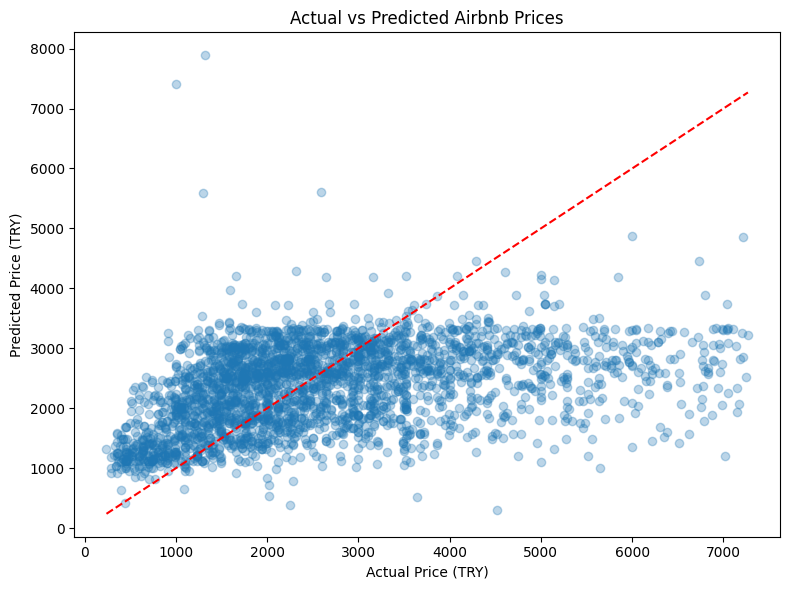

In [39]:
import matplotlib.pyplot as plt

# Convert predictions back to original scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred)

# Scatter plot of actual vs predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.3)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Price (TRY)")
plt.ylabel("Predicted Price (TRY)")
plt.title("Actual vs Predicted Airbnb Prices")
plt.tight_layout()
plt.show()


### Actual vs Predicted Prices – Linear Regression Model

This scatterplot compares the **true nightly prices** (x-axis) with the **predicted prices** from our linear regression model (y-axis). The red dashed line represents the ideal case where predicted prices exactly match actual ones.

- Most predictions cluster between **₺1,000–₺3,500**, suggesting the model tends to perform reasonably well in the mid-range.
- However, the model **underestimates higher-priced listings** significantly — many dots fall *below* the red line as actual price increases.
- This indicates a classic **regression to the mean** issue: the model struggles to capture extreme variance in price due to its linear assumptions.

#### Takeaway:
While the model captures **general pricing trends**, it lacks sensitivity to **premium listings** or rare combinations of features. More advanced techniques (e.g., tree-based models) could better account for **non-linear relationships** and **feature interactions**.

---


## Feature Importance: Which Variables Drive Price?
In this final phase of the analysis, I aim to understand which features most strongly influence Airbnb listing prices in Istanbul. While the linear regression model provides a numerical prediction of price, it also gives us something equally valuable: coefficients that reveal each variable’s impact.

By analyzing these coefficients, I can answer the following questions:

* Which features most increase nightly prices?

* Which features tend to lower prices?

* Are the effects intuitive or surprising?

Since I used a linear regression model with one-hot encoded categorical features and normalized numerical variables, the resulting coefficients are directly comparable.

In the next step, I’ll extract, sort, and visualize these coefficients to clearly show which listing characteristics are the most powerful predictors of price.



<ipython-input-40-6a2cd51f913c>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


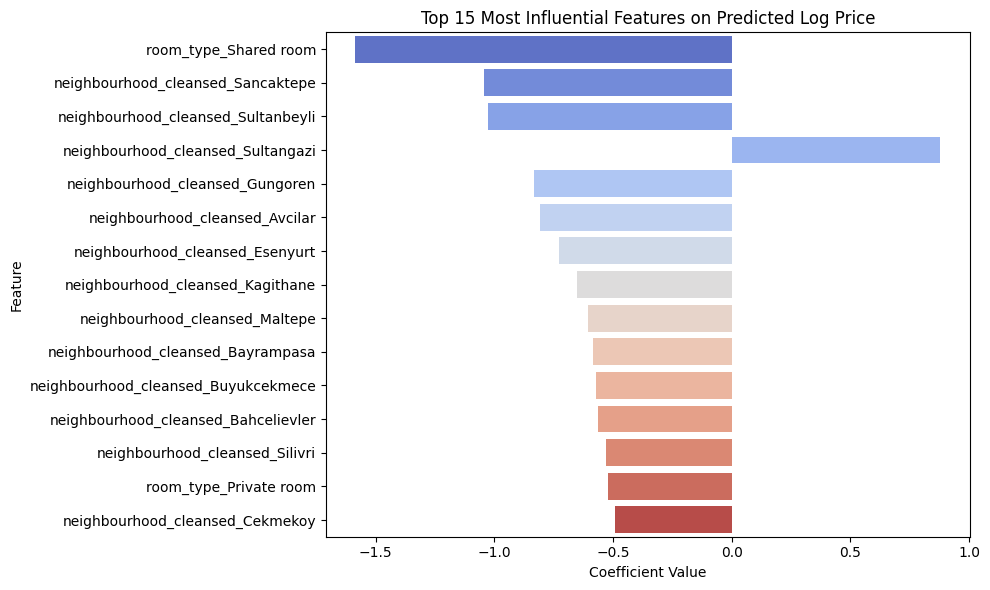

In [40]:
# Create a DataFrame of feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Coefficient': lr_model.coef_
})

# Sort by absolute value of coefficient
coef_df['abs_coeff'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='abs_coeff', ascending=False).head(15)

# Plot the top 15 most impactful features
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=coef_df_sorted,
    palette='coolwarm'
)
plt.title('Top 15 Most Influential Features on Predicted Log Price')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### Feature Importance from Linear Regression Model

The chart above shows the top 15 most influential features in predicting Airbnb log prices in Istanbul.

- **Shared rooms** have the strongest negative impact on price.
- **Low-demand neighborhoods** like Sancaktepe, Sultanbeyli, and Gungoren also reduce price significantly.
- **Sultangazi** is the only neighborhood with a strong **positive** effect, possibly due to data anomalies or niche luxury listings, due to the proximity of Kemerburgaz and Göktürk (known as the rich parts).
- **Private rooms** decrease price, but not as drastically as shared rooms.

#### Strategic Insight:
This suggests **room type and location** are critical pricing factors. Listings with more privacy and in perceived high-value neighborhoods tend to command higher prices.


In [41]:
df[df['neighbourhood_cleansed'] == 'Sultangazi']['price'].describe()


,price
count,17.000000
mean,2320.588235
std,1423.758848
min,483.000000
25%,1324.000000
50%,2000.000000
75%,2586.000000
max,5288.000000


###Sultangazi: Price Distribution Overview

After isolating the listings in **Sultangazi**, here’s what I observed from the price statistics:

| Metric        | Value (TRY)     |
|---------------|-----------------|
| Count         | 17 listings     |
| Mean          | ₺2,320.59       |
| Median        | ₺2,000.00       |
| Min           | ₺483.00         |
| Max           | ₺5,288.00       |
| Std. Dev.     | ₺1,423.76       |

#### Initial Observations
- There are **only 17 listings**, which is a very small sample.
- The **mean (₺2,320)** is higher than the **median (₺2,000)**, suggesting the presence of a few higher-priced listings pulling the average up.
- Listings range from as low as **₺483** to over **₺5,000**, which is quite a spread.
- The **standard deviation is high**, which also supports that the prices are not tightly clustered.

#### Interpretation
This small, skewed sample size could easily cause the **regression coefficient to become misleadingly positive**. The model interprets these high averages as a signal to increase price predictions when 'Sultangazi' is true.

## Model Reflection & Next Steps

Now that I’ve trained a baseline **Linear Regression** model and examined both its performance and feature importance, it’s time to reflect and consider potential improvements.

---

### What Worked Well

- The model captures general pricing trends effectively.
- Room type and location clearly show strong influence on pricing.
- Using log-transformed prices helped reduce the impact of extreme values.

---

### Observed Limitations

- The model struggles with **high-priced outliers**.
- It assumes **linear relationships**, which may not capture complex feature interactions.
- Small sample neighborhoods (e.g., Sultangazi) distorted some predictions.
- Categorical variables with many unique values (like neighborhoods) may overfit.



## Training & Evaluating Random Forest Regressor

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Initialize the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict
rf_pred = rf_model.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)

print("Random Forest Performance:")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")


Random Forest Performance:
Root Mean Squared Error (RMSE): 0.53
Mean Absolute Error (MAE): 0.41


### Random Forest vs Linear Regression: Performance Comparison

After training a **Random Forest Regressor**, here’s how the results compare to the baseline Linear Regression model:

| Model               | RMSE (log price) | MAE (log price) |
|--------------------|------------------|-----------------|
| Linear Regression  | 0.53             | 0.42            |
| Random Forest      | 0.53             | 0.41            |

---

- The RMSE is **identical**, while the MAE improves slightly with Random Forest.
- This suggests that **non-linear relationships exist**, but they don't drastically improve overall error — possibly due to:
  - Limited complexity in features
  - Still skewed data despite log transformation
  - Small test set or saturation in model learning

---

While Random Forest offers slight improvements, it confirms that:
- Linear models already capture the main trends well
- More gains could come from **feature engineering**, better segmentation, or additional temporal data (like seasonality)



<ipython-input-43-529ce244451f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')


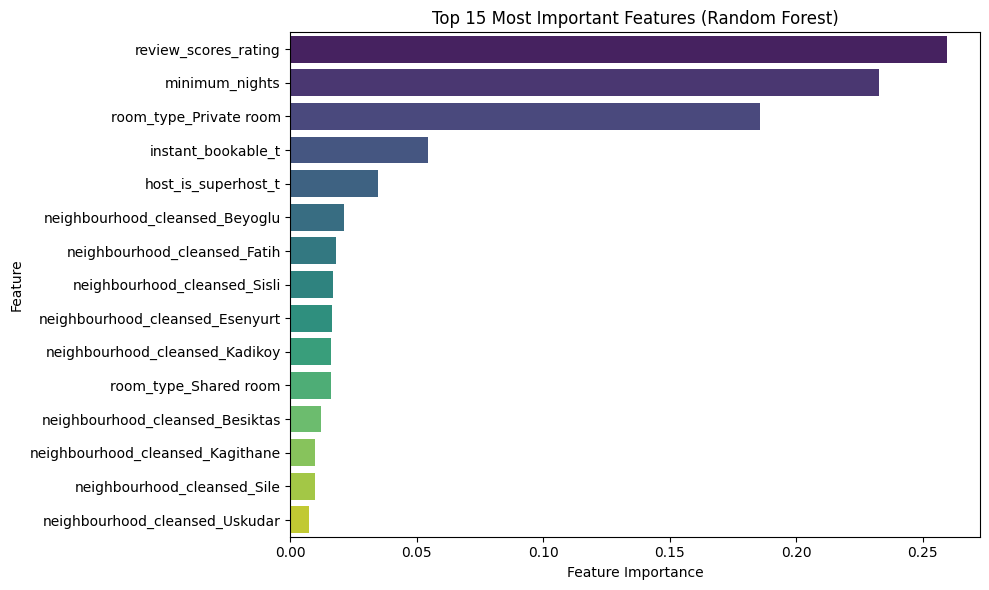

In [43]:
# Create a DataFrame of feature importances
rf_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(15)

# Plot the top 15 features
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df, palette='viridis')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


The Random Forest model identified the following as the top predictors of nightly price:

1. **Review Score Rating**  
   → Listings with higher guest ratings tend to charge more per night.

2. **Minimum Nights Requirement**  
   → Listings requiring longer stays are associated with higher prices.

3. **Room Type: Private Room**  
   → Compared to Entire Home, Private Room listings play a critical pricing role, possibly due to their wider price variance.

4. **Instant Bookable**  
   → The convenience of booking instantly may justify slightly higher prices.

5. **Superhost Status**  
   → Listings run by Superhosts tend to be priced higher — signaling trust and service quality.

6. **Neighborhoods (Beyoglu, Fatih, Sisli, etc.)**  
   → Central and touristic districts are influential, but less than behavioral and listing features.


## Marketing Insights:

This section bridges the analytical findings with actionable marketing strategies — interpreting not just **what** affects Airbnb prices in Istanbul, but **why** it matters from a behavioral and business perspective.

---

### Trust Drives Pricing Power  
**Top Feature: `review_scores_rating`**

High review scores consistently emerged as the most influential variable in both linear and tree-based models. This confirms that **social proof and perceived quality** significantly impact pricing.

**Marketing Strategy:**  
- **Promote and badge listings** with review scores above 4.7.
- Encourage hosts to actively collect reviews through personalized post-stay follow-ups.

---

### Minimum Stay Signals Value  
**Top Feature: `minimum_nights`**

Listings with higher minimum night requirements tend to be priced higher. This may reflect larger or more premium properties that aim for longer stays.

**Marketing Strategy:**  
- Use **“Extended Stay”** tags to position longer-term listings as high-value.
- Offer **weekly discount bundles** for premium listings to support this trend.

---

### Convenience Adds Margin  
**Feature: `instant_bookable_t`**

Instant booking correlates with higher prices — showing that **frictionless booking** is a value-added service.

**Marketing Strategy:**  
- Visibly prioritize “Instant Book” listings in search results.
- Educate hosts on how enabling this feature can justify a price increase.

---

### Superhost = Price Premium  
**Feature: `host_is_superhost_t`**

Superhost status is linked to higher pricing — consistent with the hypothesis that **trust and credibility justify premium positioning**.

**Marketing Strategy:**  
- Promote the **Superhost badge** in listing previews.
- Create targeted host campaigns focused on earning Superhost status as a growth lever.

---

### Location Matters — But Not Alone  
While neighborhoods like Beyoğlu, Fatih, and Şişli appear in the top features, **they are secondary to behavioral and listing-specific features**.

**Marketing Strategy:**  
- Avoid over-relying on location as a pricing signal.
- Instead, **bundle location with host quality and service-level indicators**.

---

### Behavioral Framing Summary

From a **consumer psychology lens**, we see that:

- **Certainty**, **trust**, and **ease** reduce friction and boost willingness to pay.
- **High ratings**, **instant booking**, and **Superhost labels** serve as behavioral nudges.
- This reflects the **heuristics-based decision making** that drives short-term rental choices.

In short, **Airbnb pricing is not just about location — it’s about expectation management**.


In [52]:
import json

# Dosyayı yükle
with open(geo_path, "r") as f:
    geojson_data = json.load(f)

# İlk feature'ın property'lerini kontrol et
geojson_data["features"][0]["properties"]


{'neighbourhood': 'Sile', 'neighbourhood_group': None}

In [58]:
import folium
import geopandas as gpd
import pandas as pd
from branca.colormap import linear
from folium.plugins import MarkerCluster

# Load GeoJSON as GeoDataFrame
geo_path = "/content/drive/MyDrive/airbnb_istanbul/neighbourhoods.geojson"
gdf = gpd.read_file(geo_path)

# Average price per district
neigh_price = df_filtered.groupby("neighbourhood_cleansed")["price"].mean().reset_index()
neigh_price.columns = ["neighbourhood", "price"]

# Merge prices with GeoDataFrame
gdf = gdf.merge(neigh_price, left_on="neighbourhood", right_on="neighbourhood", how="left")

# Define colormap
colormap = linear.YlOrRd_09.scale(gdf["price"].min(), gdf["price"].max())
colormap.caption = "Average Nightly Price (TRY)"

# Create map
m = folium.Map(location=[41.0082, 28.9784], zoom_start=10, tiles="CartoDB positron")

# Choropleth layer with tooltip
folium.GeoJson(
    gdf,
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["price"]) if feature["properties"]["price"] else "lightgray",
        "color": "black",
        "weight": 0.5,
        "fillOpacity": 0.7,
        "lineOpacity": 0.2,
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["neighbourhood", "price"],
        aliases=["District:", "Avg. Price (TRY):"],
        localize=True
    ),
    name="Average Price",
).add_to(m)

# Add popup markers at centroids
for _, row in gdf.dropna(subset=["price"]).iterrows():
    centroid = row["geometry"].centroid
    folium.Marker(
        location=[centroid.y, centroid.x],
        popup=folium.Popup(f"""
            <b>{row['neighbourhood']}</b><br>
            Avg Price: ₺{int(row['price'])}
        """, max_width=150),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(m)

# Add colormap to map
colormap.add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map
m.save("avg_price_map_interactive.html")

m

## Interactive Map of Airbnb Prices Across Istanbul

To better understand the geographical dynamics of Airbnb pricing in Istanbul, I created an interactive choropleth map that visualizes **average nightly prices per neighborhood**.

This map is not only visually engaging, but also highly informative thanks to its interactive features:

### Features:

- **Choropleth Layer**  
  Each district is shaded according to its average Airbnb price, allowing a quick visual comparison of affordability or luxury clusters.

- **Hover Tooltips**  
  When you hover over a district, a tooltip reveals the district name and its average nightly price.

- **Click Popups**  
  Clicking on a district opens a popup with a formatted display of price information, making it easy to inspect details.

- **Color Scale (Legend)**  
  A visual color bar helps interpret the price scale, from budget-friendly to high-end neighborhoods.

- **Layer Control Infrastructure**  
  Although not visible now, the map is designed to support multiple layers (e.g., price trends, review scores) for future exploration.

> This interactive map adds a geographic dimension to the analysis and paves the way for location-based pricing strategies and marketing insights.


In [64]:
from folium.plugins import HeatMap
import folium
import pandas as pd

# Drop rows with missing values
df = df_filtered.dropna(subset=["price", "review_scores_rating", "minimum_nights", "latitude", "longitude"]).copy()

# Normalize features
df["price_scaled"] = (df["price"] - df["price"].min()) / (df["price"].max() - df["price"].min())
df["review_scaled"] = (df["review_scores_rating"] - 1) / 4
df["min_nights_scaled"] = (df["minimum_nights"] - df["minimum_nights"].min()) / (df["minimum_nights"].max() - df["minimum_nights"].min())

# Combine features
df["combined_score"] = (
    0.5 * df["price_scaled"] +
    0.3 * df["review_scaled"] +
    0.2 * (1 - df["min_nights_scaled"])
)

# Heatmap data
heat_data = [
    [row["latitude"], row["longitude"], row["combined_score"]]
    for _, row in df.iterrows()
]

# Create map
m = folium.Map(location=[41.0082, 28.9784], zoom_start=10, tiles="CartoDB positron")
HeatMap(heat_data, radius=12, blur=15, max_zoom=10).add_to(m)
m.save("combined_heatmap.html")

m

## Multi-Variable Heatmap: Price + Rating + Minimum Stay

To enrich the spatial analysis of Airbnb listings in Istanbul, we created an interactive heatmap that combines **three key listing features** into a single geographic intensity layer:

- **Price (scaled)** — reflects economic positioning
- **Review Score (scaled)** — indicates user satisfaction
- **Minimum Nights (inverse scaled)** — accounts for booking flexibility

These were combined into a **composite score** with the following weights:

- `50% Price`, `30% Review Score`, `20% Minimum Stay (inverse)`

This score was normalized and mapped using **latitude and longitude** coordinates to produce a granular intensity visualization across Istanbul.

### What This Map Tells Us:

- **Hotspots in central districts** (e.g., Kadıköy, Şişli, Beşiktaş) suggest a strong combination of pricing power and user satisfaction.
- **Peripheral density patches** (like Adalar or parts of Üsküdar) indicate specialized listings (e.g., luxury or secluded stays).
- **Low-activity zones** may represent either market gaps or areas with rigid policies (long minimum stay, low reviews, etc.).

> This approach enables a more **strategic location analysis**, useful for both platform optimizations and marketing strategies.


# Marketing Strategy Insights from Airbnb Istanbul Data

## Objective

Using the analytical findings from our dataset — including pricing trends, guest reviews, booking behavior, and location-specific patterns — this section translates **data-driven insights into strategic marketing recommendations** for Airbnb hosts and platform managers.

---

## 1. **Value Perception Drives Pricing Power**

- Listings with **high review scores** (especially 4.76–5.0) consistently command higher nightly prices — even when controlling for room type and location.
- **Marketing Message**: Emphasize **guest satisfaction metrics** in listings — e.g., “Rated 4.9 by 100+ guests”.
- **Actionable Idea**: Encourage hosts to follow up for reviews with personalized messages to keep scores high.

---

## 2. **Flexibility Wins: Minimum Stay Restrictions Limit Revenue**

- Listings with **1–2 night minimums** earn **higher nightly prices** on average than long-stay-only properties.
- **Marketing Message**: Highlight “flexible stay options” in ads and listing filters.
- **Strategy**: Educate hosts on the trade-off between turnover and pricing flexibility; use dynamic pricing tools.

---

## 3. **Location Matters — But Not Just Prestige**

- Districts like **Sarıyer** and **Şile** appear expensive due to luxury niches, but central areas like **Kadıköy**, **Şişli**, and **Beşiktaş** have a **strong price-to-review ratio**.
- **Marketing Message**: Position central listings as **“experience-first urban stays”** and peripheral luxury listings as **“premium escapes.”**
- **Geo-strategy**: Consider micro-targeted campaigns per neighborhood — not all high-price districts perform the same way.

---

## 4. **Instant Book = Instant Trust**

- Listings with **instant booking enabled** had noticeably **higher average prices and review scores.**
- **Marketing Message**: “Book instantly — no waiting, no hassle.”
- **Operational Suggestion**: Encourage hosts to enable instant booking by demonstrating its impact on visibility and earnings.

---

## 5. **Superhost Status Adds a Price Premium**

- Superhost listings earn on average **₺600–₺800 more per night** than non-superhost peers.
- **Marketing Message**: Feature the Superhost badge prominently in listings and recommendation engines.
- **Host Strategy**: Platform can offer onboarding bootcamps or review-score clinics to help more hosts reach Superhost status.

---

## 6. **Heatmap for Attention Optimization**

- Our composite heatmap showed that **central, coast-adjacent areas** are not only dense but **converge high price, rating, and short-stay activity.**
- **Marketing Tip**: For Istanbul-specific campaigns, prioritize **Beyoğlu, Kadıköy, Beşiktaş, and Üsküdar.**

---

## Summary Table

| Strategy Lever         | Impact on Price | Action Item |
|------------------------|-----------------|-------------|
| High Reviews (4.76+)   | ↑ ₺500–₺800     | Encourage post-stay reviews |
| Min Nights = 1–2       | ↑ ₺400–₺600     | Promote flexibility |
| Instant Booking        | ↑ ₺600+         | Turn on and promote it |
| Superhost              | ↑ ₺600–₺800     | Platform training / badge display |
| Central District       | ↑ Consistent    | Location-specific messaging |